In [1]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from tqdm import tqdm


In [2]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/aerial"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/aerial/03_model_weights/resnet"
MODEL_NAME = "20240321_1625"

In [3]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [4]:
config

{'mean_RGB_values_path': 'data/01_raw_images/rgb_means.npy',
 'ml_data_dir': 'data/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 32,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/03_model_weights/resnet',
 'probas_dir': 'data/04_predictions'}

In [5]:
IMG_SIZE = 128


In [6]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [7]:
def load_data(pred_probas_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, labels


In [8]:
cal_pred_probas, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_LABELS)


0it [00:00, ?it/s]

1500it [00:07, 194.53it/s]


In [9]:
test_pred_probas, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_LABELS)

2300it [00:10, 216.94it/s]


In [10]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]

In [11]:
cal_labels.shape, cal_pred_probas.shape

((1225, 128, 128), (1225, 128, 128))

In [12]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [29]:
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
for i in tqdm(range(len(cal_pred_probas))):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

100%|██████████| 1225/1225 [00:36<00:00, 33.88it/s]


In [45]:
ALPHA = .1
_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star
th_crc


array([0.17])

In [46]:
y_pred_test_th = (test_pred_probas >= th_crc).astype(int)

recall_test = (y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

/tmp/ipykernel_838714/2134985871.py:3: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))


In [47]:
np.nanmean(recall_test)

0.924151987492148

In [48]:
precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
np.mean(precision_test)

/tmp/ipykernel_838714/3317103724.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)


0.7060167709761536

(array([109.,   8.,  12.,  19.,  57., 174., 584., 764., 225., 348.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

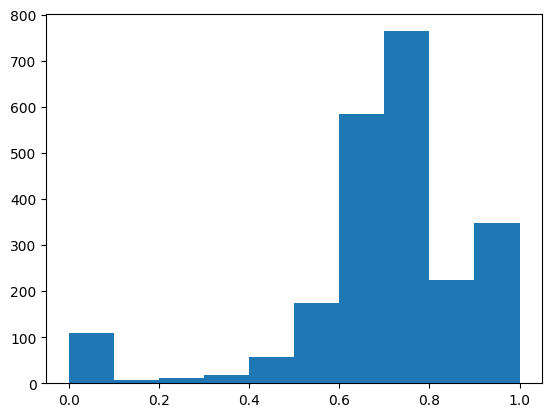

In [49]:
plt.hist(precision_test)

In [50]:
precision_test.shape

(2300,)

In [51]:
np.median(precision_test)

0.7236024844720497

In [59]:
recalls = []
precisions = []
for th in tqdm(np.arange(0, 1, .01)):
    pred_th = test_pred_probas >= th
    recall = (pred_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
    precision = np.nan_to_num((pred_th * test_labels).sum(axis=(1, 2)) / pred_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall))
    precisions.append(np.nanmean(precision))

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_838714/2473603847.py:5: RuntimeWarning: invalid value encountered in divide
  recall = (pred_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
  1%|          | 1/100 [00:00<00:34,  2.86it/s]/tmp/ipykernel_838714/2473603847.py:6: RuntimeWarning: invalid value encountered in divide
  precision = np.nan_to_num((pred_th * test_labels).sum(axis=(1, 2)) / pred_th.sum(axis=(1, 2)), nan=1)
100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


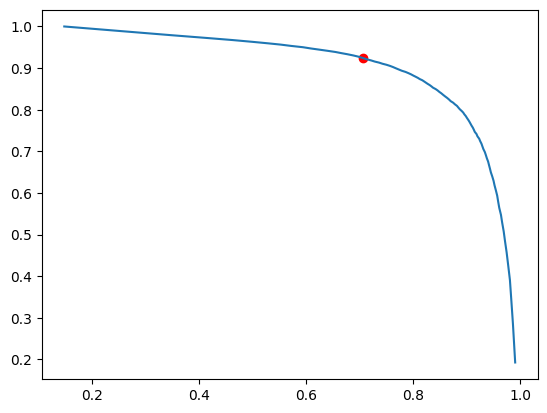

In [60]:
plt.plot(precisions, recalls)
plt.scatter(np.nanmean(precision_test), np.nanmean(recall_test), c="r")

In [44]:
np.arange(0, 1, .01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [57]:
recalls[17], np.nanmean(recall_test)

(0.924151987492148, 0.924151987492148)

In [58]:
precisions[17], np.nanmean(precision_test)

(0.6591928292566296, 0.7060167709761536)